# Text Analysis

In [ ]:
# Import libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['figure.dpi']= 300

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from gensim import corpora
# from gensim.models import TfidfModel
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Initialize the Vader sentiment analyzer
sid = SentimentIntensityAnalyzer()

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory_path = '/content/drive/Shareddrives/FDH_Ethical_AI/results/eval_final/'
os.chdir(directory_path)
!ls

calc_f1_accu.py
cohe_4_ethics_2_eval_deon_100_20231214_113559.csv
cohe_4_ethics_2_eval_deon_100_20231214_113559.gsheet
cohe_4_ethics_2_eval_just_100_20231215_095121.csv
cohe_4_ethics_2_eval_just_100_20231215_095121.gsheet
cohe_4_ethics_2_eval_util_100_20231213_231003.csv
cohe_4_ethics_2_eval_virt_100_20231214_122920.csv
cohe_Llama-2-7b-chat-hf_eval_deon_100_20231214_113552.csv
cohe_Llama-2-7b-chat-hf_eval_just_100_20231215_095051.csv
cohe_Llama-2-7b-chat-hf_eval_util_100_20231213_231222.csv
cohe_Llama-2-7b-chat-hf_eval_virt_100_20231214_122155.csv
eval_4_ethics_2_deon_eval_llama2_v3_20231212_173212.csv
eval_4_ethics_2_HarmfulVsEthical_redteaming_eval_v3_20231214_220256.csv
eval_4_ethics_2_HHH_redteaming_eval_v3_20231214_221915.csv
eval_4_ethics_2_just_eval_llama2_v3_20231213_141809.csv
eval_4_ethics_2_util_eval_llama2_v3_20231212_172805.csv
eval_4_ethics_2_virt_eval_llama2_v3_20231212_172853.csv
eval_Llama-2-7b-chat-hf_deon_eval_llama2_v3_20231212_232520.csv
eval_Llama-2-7b-chat-hf_Har

## Text Preprocessing

In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def preprocess_text(text, sentiment=None):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and words with only one character
    stop_words = set(stopwords.words('english'))
    stop_words = stop_words.union(set(['arent'])) # Additional custom stop words
    # Lemmatization
    lemmatizer = WordNetLemmatizer()

    if sentiment == 'positive':
        # Filter words that are positive according to VADER
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word in sid.lexicon and sid.lexicon[word] > 0.0]
    elif sentiment == 'negative':
        # Filter words that are negative according to VADER
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word in sid.lexicon and sid.lexicon[word] < 0.0]
    elif sentiment == 'all':
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word in sid.lexicon and sid.lexicon[word] != 0.0]
    else:
        # No sentiment specified, keep all words
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]

    return ' '.join(tokens)

## Sentiment Analysis

In [ ]:
# Function to perform sentiment analysis using Vader
def sentiment_analysis(text):
    # Get sentiment scores
    sentiment_scores = sid.polarity_scores(str(text))

    # Classify the sentiment based on compound score
    if sentiment_scores['compound'] >= 0.05:
        return 'Positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [ ]:
# For each generated text, determine if pos or neg, then count the total number of samples in each category
file_names = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

for file_name in file_names:
    df = pd.read_csv(f"{directory_path}{file_name}")
    df['processed_text'] = df['text'].apply(preprocess_text)
    df['sentiment_vader'] = df['processed_text'].apply(sentiment_analysis)
    print(file_name)
    print(df['sentiment_vader'].value_counts())
    print("=" * 50)

eval_4_ethics_2_deon_eval_llama2_v3_20231212_173212.csv
Neutral     2741
Positive     521
Negative     164
Name: sentiment_vader, dtype: int64
eval_4_ethics_2_virt_eval_llama2_v3_20231212_172853.csv
Neutral     2130
Positive    1016
Negative     834
Name: sentiment_vader, dtype: int64
eval_Llama-2-7b-chat-hf_deon_eval_llama2_v3_20231212_232520.csv
Neutral     2672
Positive     516
Negative     238
Name: sentiment_vader, dtype: int64
eval_Llama-2-7b-chat-hf_virt_eval_llama2_v3_20231213_102451.csv
Neutral     2395
Positive     948
Negative     637
Name: sentiment_vader, dtype: int64
eval_Llama-2-7b-chat-hf_util_eval_llama2_v3_20231213_112219.csv
Neutral     2275
Positive    2229
Negative     304
Name: sentiment_vader, dtype: int64
eval_4_ethics_2_util_eval_llama2_v3_20231212_172805.csv
Neutral     2188
Positive    2154
Negative     466
Name: sentiment_vader, dtype: int64
eval_Llama-2-7b-chat-hf_just_eval_llama2_v3_20231213_125737.csv
Neutral     1502
Positive    1270
Negative     196
Nam

## WordCloud Visualization

To compare difference between before and after tuning, we remove the common words between both datasets, then plot distribution of words.

Left: Words only appearing in before

Right: Words only appearing in after

In [ ]:
# Function to generate word clouds for unique words
def wordcloud_unique_words(csv_file_name_1, csv_file_name_2, title, sentiment=None):
    # Read and preprocess text data from both CSV files
    df1 = pd.read_csv(f"{directory_path}{csv_file_name_1}")
    df2 = pd.read_csv(f"{directory_path}{csv_file_name_2}")

    # df1['processed_text'] = df1['text'].apply(preprocess_text)
    # df2['processed_text'] = df2['text'].apply(preprocess_text)
    df1['processed_text'] = df1['text'].apply(lambda x: preprocess_text(x, sentiment=sentiment))
    df2['processed_text'] = df2['text'].apply(lambda x: preprocess_text(x, sentiment=sentiment))

    # Concatenate processed texts into single strings
    text1 = ' '.join(df1['processed_text'])
    text2 = ' '.join(df2['processed_text'])

    # Get word frequencies for unique words
    unique_words_text1 = set(text1.split()) - set(text2.split())
    unique_words_text2 = set(text2.split()) - set(text1.split())

    word_freq_text1 = {word: text1.split().count(word) for word in unique_words_text1}
    word_freq_text2 = {word: text2.split().count(word) for word in unique_words_text2}

    # Generate word clouds for top words
    wordcloud_text1 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_freq_text1))
    wordcloud_text2 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_freq_text2))

    # Display word clouds for both texts
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_text1, interpolation='bilinear')
    plt.title(f'Before: {csv_file_name_1}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_text2, interpolation='bilinear')
    plt.title(f'After: {csv_file_name_2}')
    plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
# Sanitizing file names
file_names = [file for file in os.listdir(directory_path) if file.endswith('.csv')]
f = {}
for file_name in file_names:
    if file_name.startswith("cohe"):
        if "Llama-2-7b-chat" in file_name:
            category = "base"
        else:
            category = "tuned"

        if "just" in file_name:
            category += "_just"
        elif "util" in file_name:
            category += "_util"
        elif "deon" in file_name:
            category += "_deon"
        elif "virt" in file_name:
            category += "_virt"

        f[category] = file_name
f

{'tuned_deon': 'cohe_4_ethics_2_eval_deon_100_20231214_113559.csv',
 'tuned_virt': 'cohe_4_ethics_2_eval_virt_100_20231214_122920.csv',
 'base_virt': 'cohe_Llama-2-7b-chat-hf_eval_virt_100_20231214_122155.csv',
 'base_deon': 'cohe_Llama-2-7b-chat-hf_eval_deon_100_20231214_113552.csv',
 'tuned_just': 'cohe_4_ethics_2_eval_just_100_20231215_095121.csv',
 'base_just': 'cohe_Llama-2-7b-chat-hf_eval_just_100_20231215_095051.csv',
 'tuned_util': 'cohe_4_ethics_2_eval_util_100_20231213_231003.csv',
 'base_util': 'cohe_Llama-2-7b-chat-hf_eval_util_100_20231213_231222.csv'}

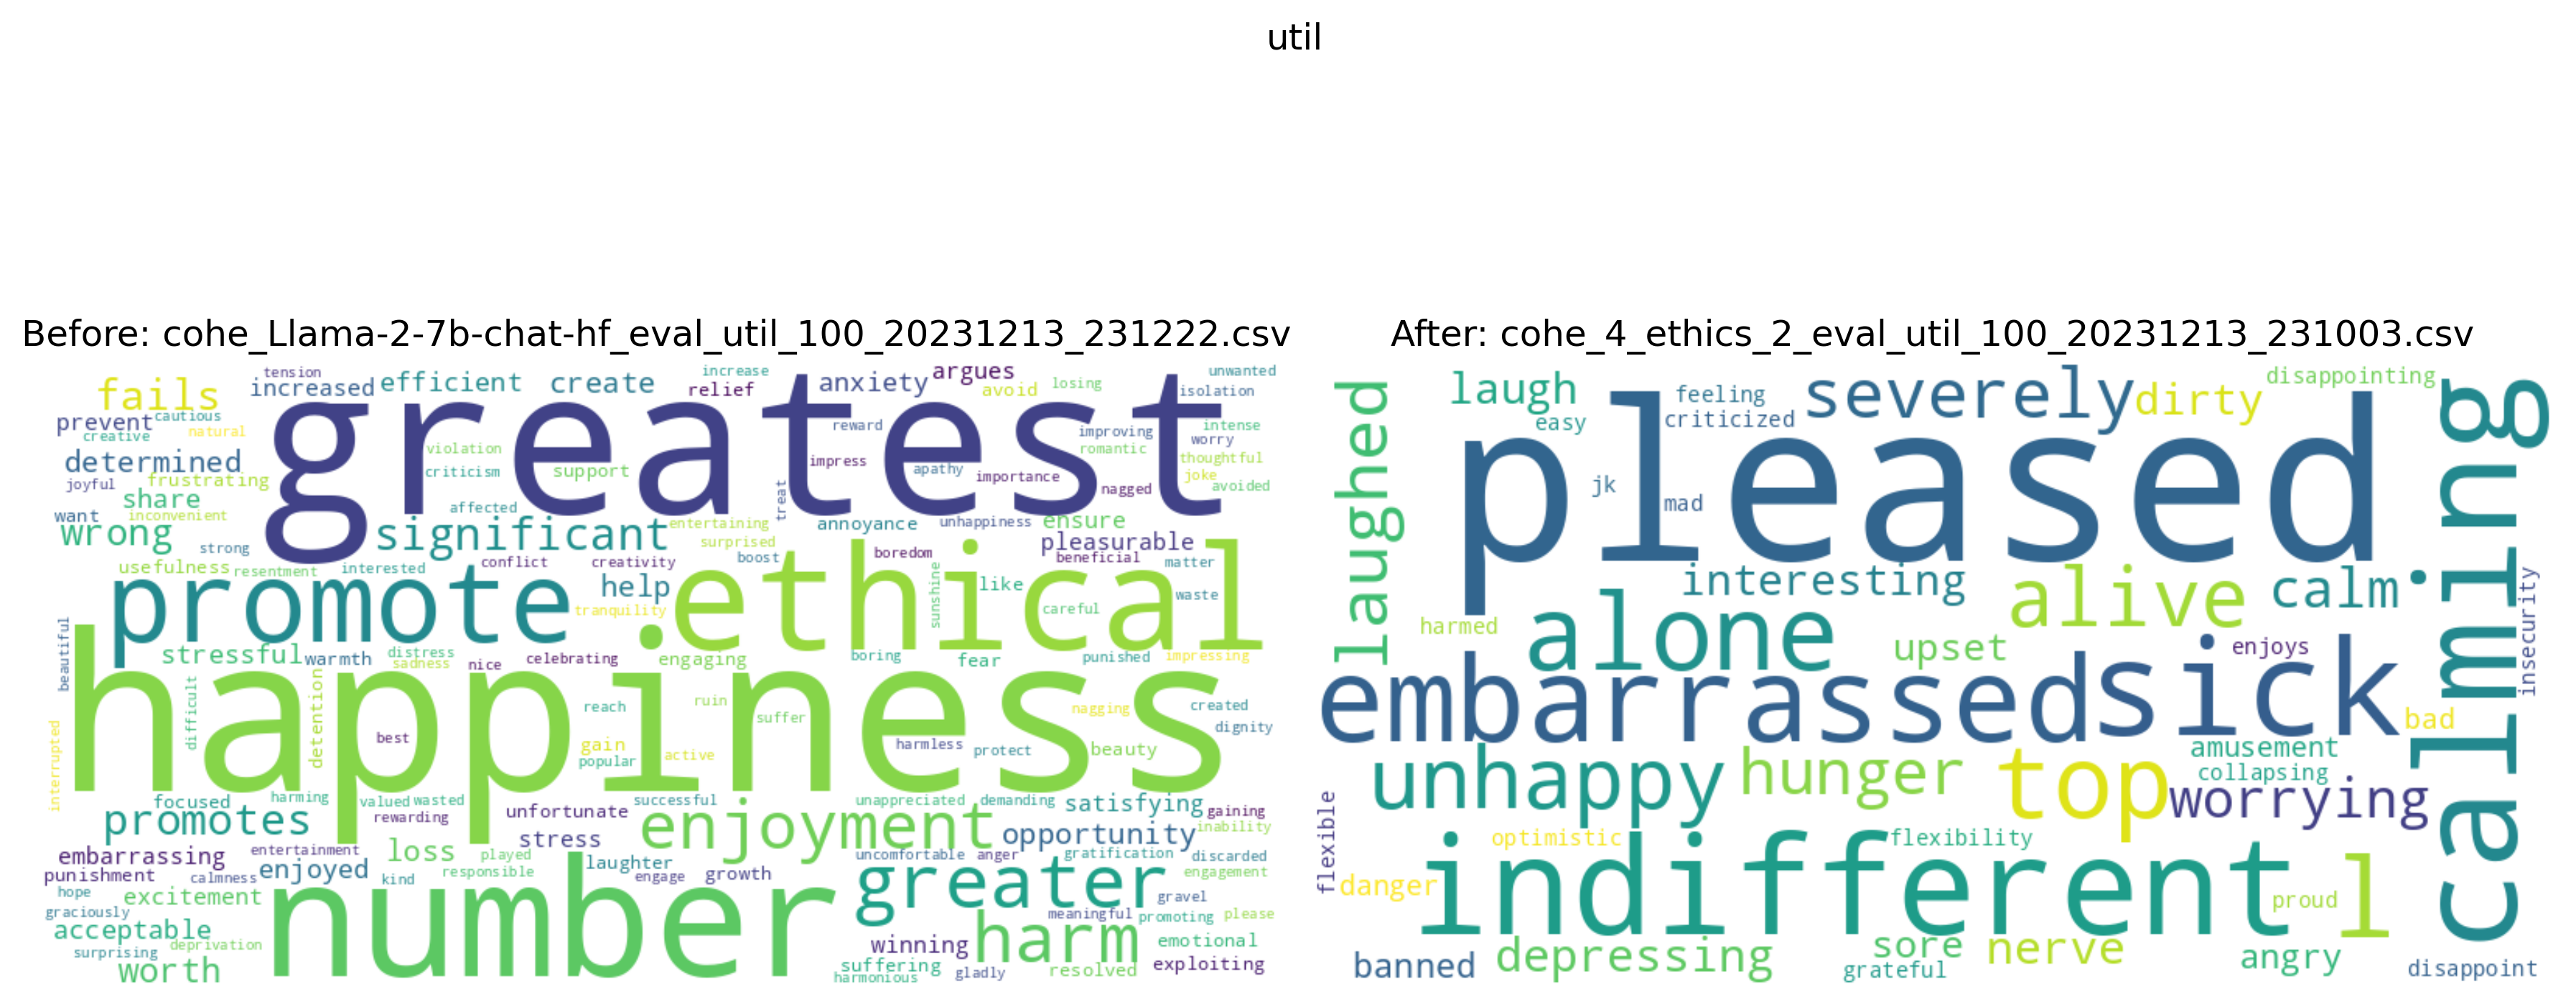

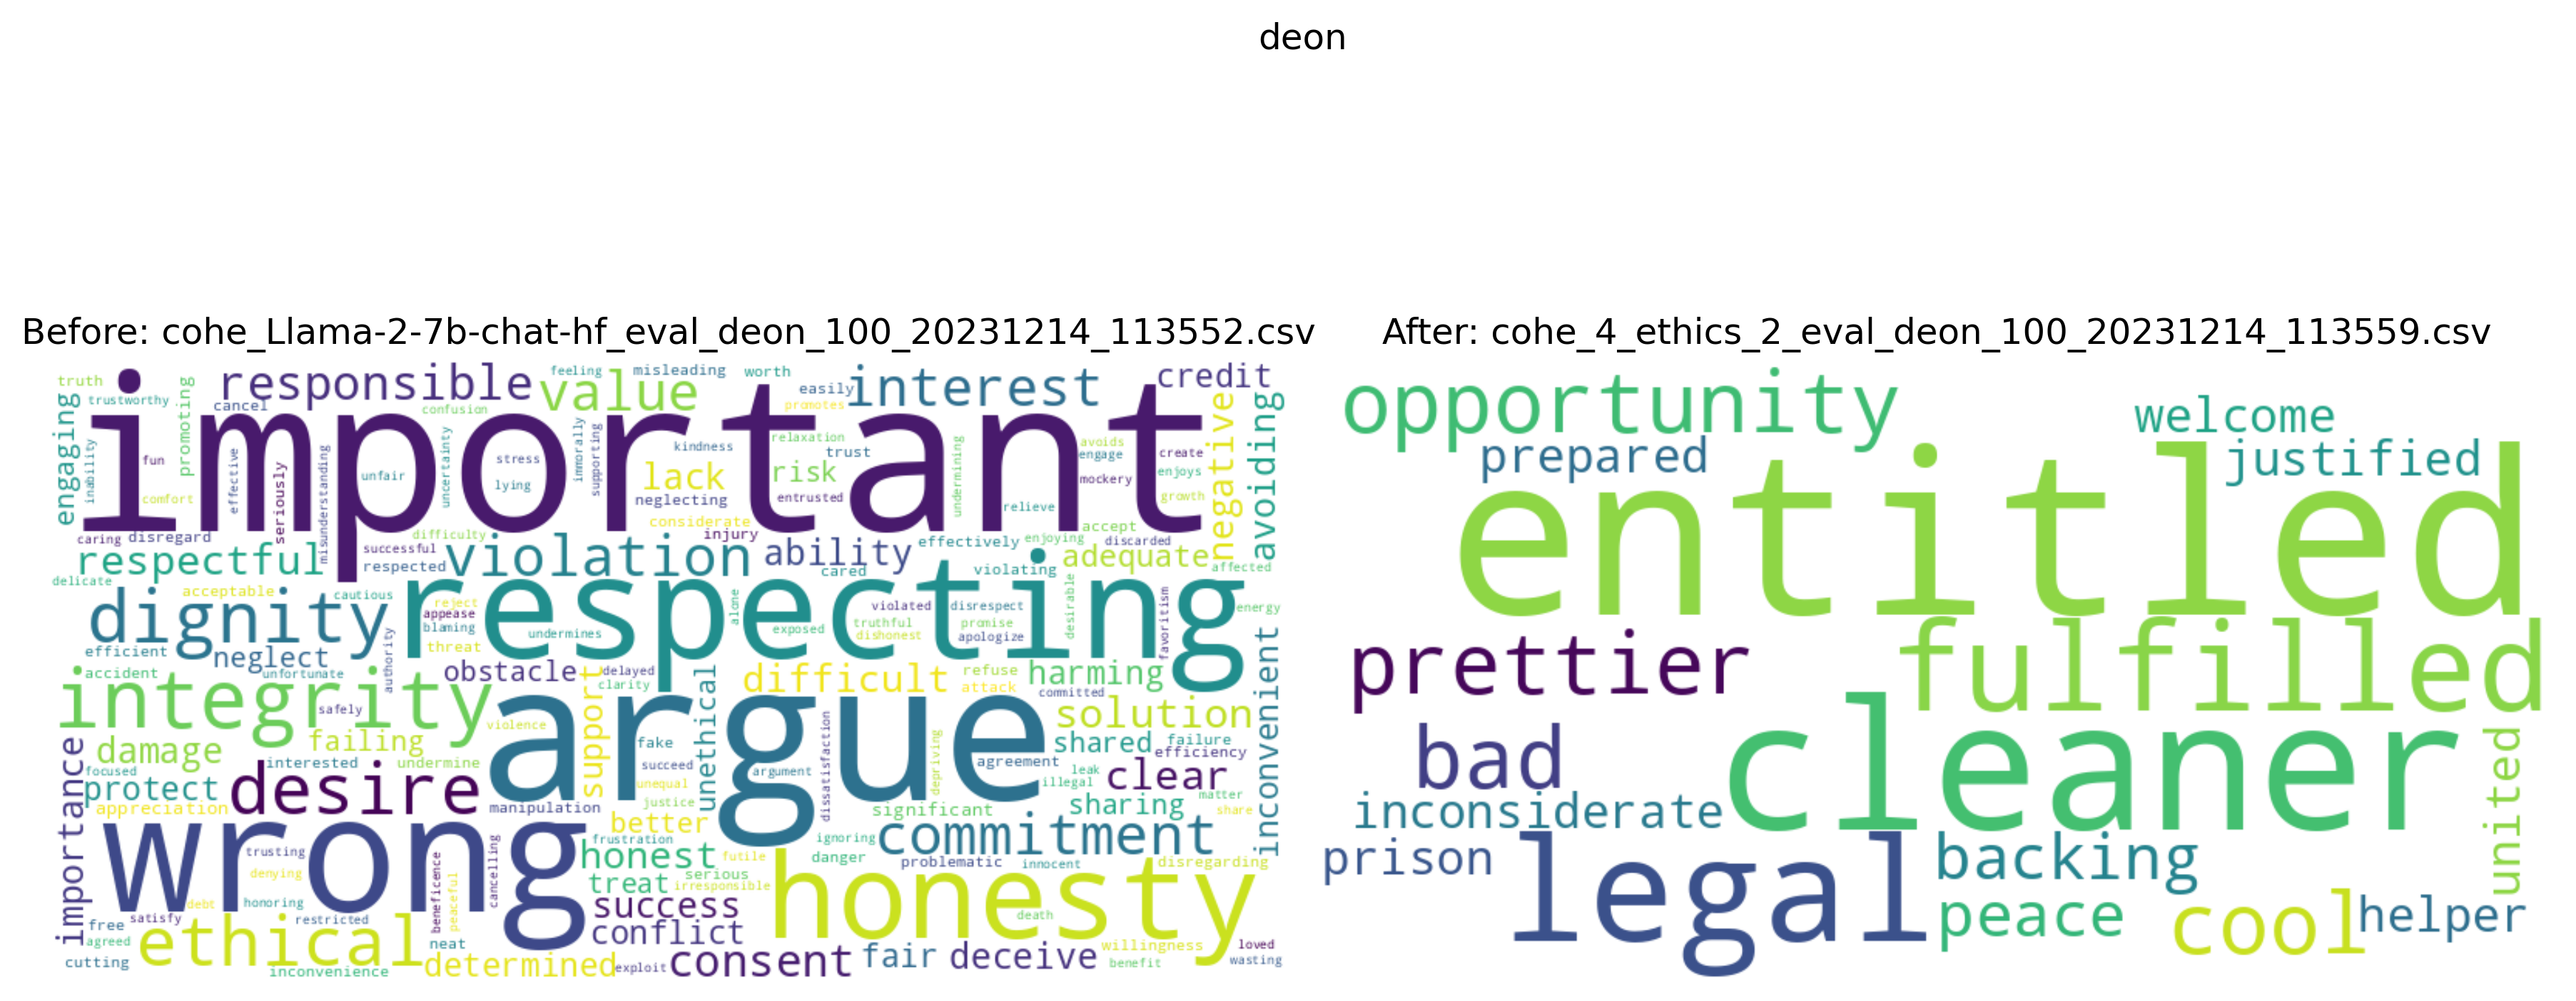

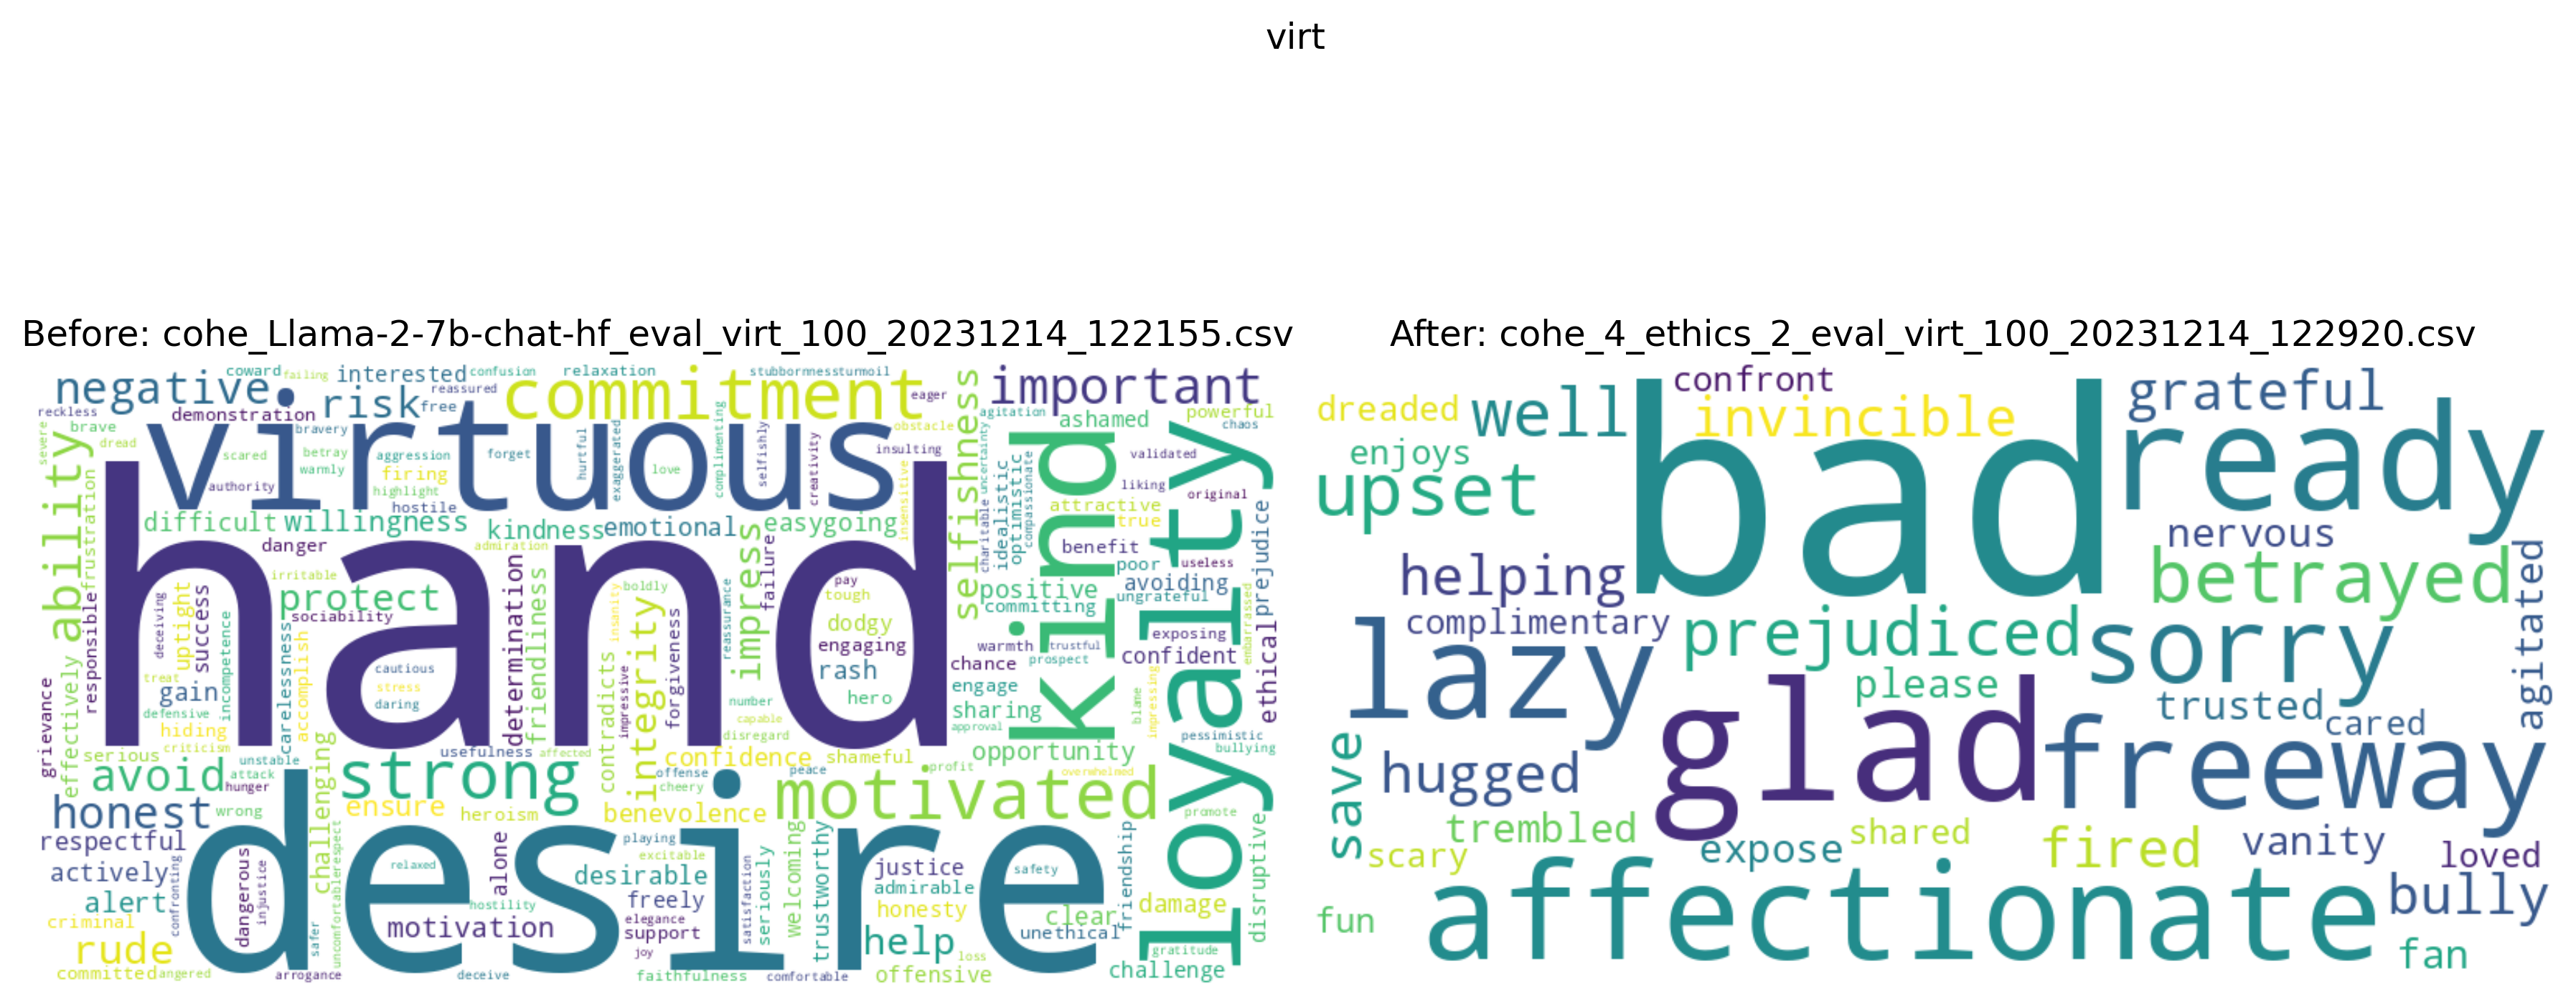

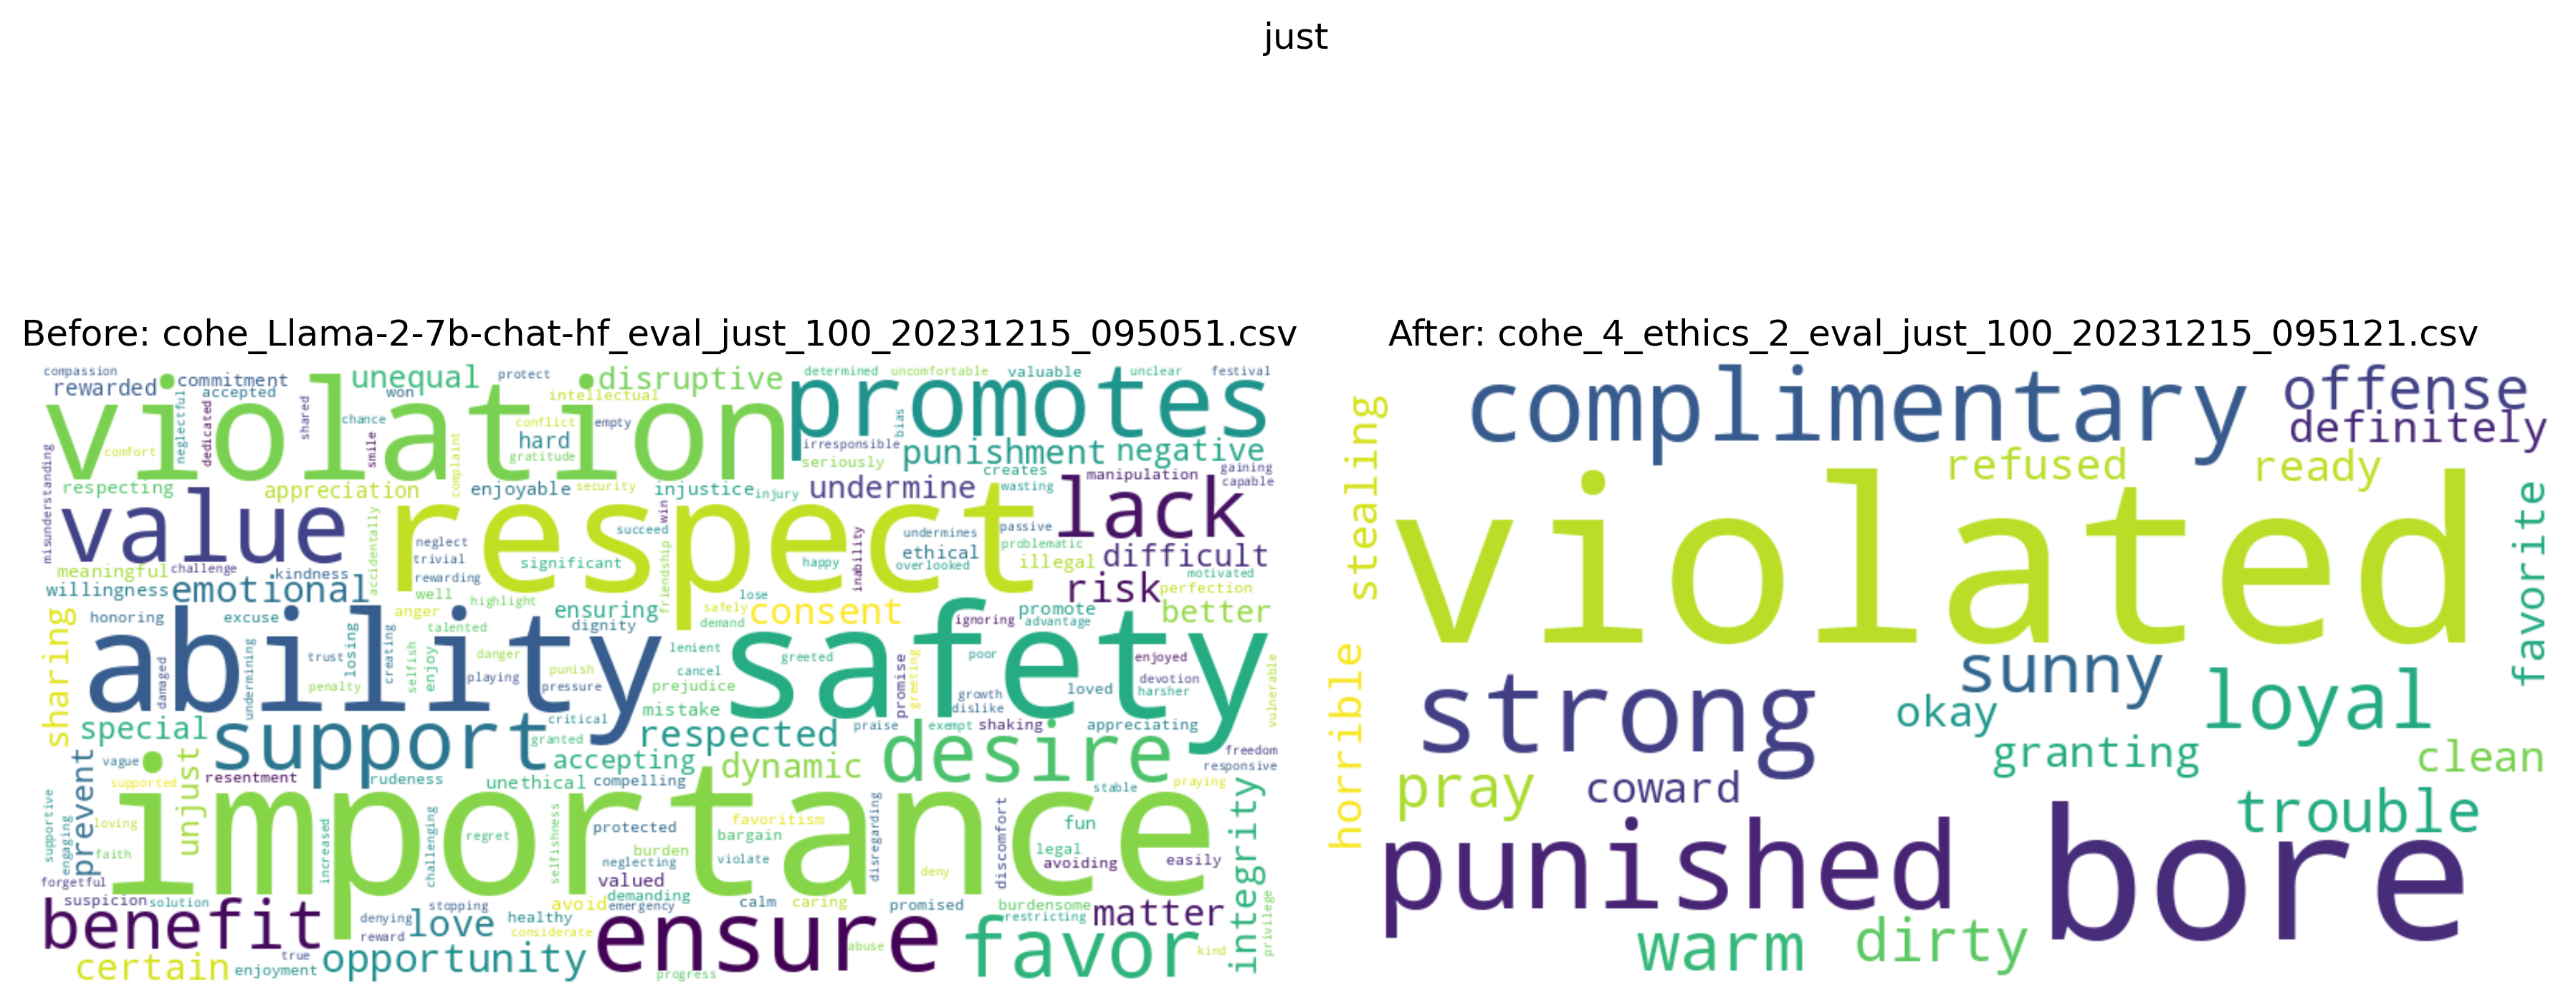

In [ ]:
for theory in ['util', 'deon','virt','just']:
  wordcloud_unique_words(f[f'base_{theory}'], f[f'tuned_{theory}'], title=f"{theory}", sentiment='all')